In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Pfad zum Ordner, der die CSV-Dateien enthält
folder_path = r'C:\Users\vogtr\OneDrive - Rapp AG\Desktop\Hackdays\GitHub\EDHD_2024_BKW_Predicting_aFRR_Volumes\Data\Training'

# Liste der Dateinamen-Muster
input_features_files = [f for f in os.listdir(folder_path) if f.startswith('input_features_') and f.endswith('.csv')]
afrr_activation_files = [f for f in os.listdir(folder_path) if f.startswith('afrr_activation_') and f.endswith('.csv')]

# Initialisiere leere Listen, um die DataFrames zu speichern
input_features_dfs = []
afrr_activation_dfs = []

# Lies die input_features Dateien ein
for file in input_features_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    input_features_dfs.append(df)

# Lies die afrr_activation Dateien ein
for file in afrr_activation_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    afrr_activation_dfs.append(df)

# Kombiniere alle DataFrames in einen einzigen DataFrame für jede Gruppe
input_features_df = pd.concat(input_features_dfs, ignore_index=True)
afrr_activation_df = pd.concat(afrr_activation_dfs, ignore_index=True)

# Ausgabe der kombinierten DataFrames
print("Input Features DataFrame:")
print(input_features_df.head())

print("\nAFRR Activation DataFrame:")
print(afrr_activation_df.head())




Input Features DataFrame:
            Unnamed: 0  Generation_CH_HydroLake  \
0  2018-01-01 00:00:00                    279.0   
1  2018-01-01 00:15:00                    279.0   
2  2018-01-01 00:30:00                    279.0   
3  2018-01-01 00:45:00                    279.0   
4  2018-01-01 01:00:00                    286.0   

   Generation_CH_HydroPumpedStorage  Generation_CH_HydroRunOfRiver  \
0                              54.0                          118.0   
1                              54.0                          118.0   
2                              54.0                          118.0   
3                              54.0                          118.0   
4                              66.0                          113.0   

   Generation_CH_Solar  Generation_CH_Nuclear  InstalledCapacity_CH_HydroLake  \
0                  0.0                 2816.0                          5405.0   
1                  0.0                 2816.0                          5405.0   
2  

In [4]:
df_join = input_features_df
df_join['ActivatedBalancingVolume_CH_aFRRPositive'] = afrr_activation_df['ActivatedBalancingVolume_CH_aFRRPositive']
df_join['ActivatedBalancingVolume_CH_aFRRNegative'] = afrr_activation_df['ActivatedBalancingVolume_CH_aFRRNegative']

In [5]:
# Liste der Spaltennamen im DataFrame
all_columns = df_join.columns

# Filter für Generation- und Consumption-Spalten
generation_columns = [col for col in all_columns if 'Generation' in col]
consumption_columns = [col for col in all_columns if 'Consumption' in col]

# Erstelle DataFrames für die Generation- und Consumption-Spalten
generation_df = df_join[generation_columns]
consumption_df = df_join[consumption_columns]



In [42]:
df_join.head()

# Assuming df_join is your DataFrame
df_join_cleaned = df_join.drop(columns=['Unnamed: 0'])

# Display the first few rows of the cleaned DataFrame
print(df_join_cleaned.head())


   Generation_CH_HydroLake  Generation_CH_HydroPumpedStorage  \
0                    279.0                              54.0   
1                    279.0                              54.0   
2                    279.0                              54.0   
3                    279.0                              54.0   
4                    286.0                              66.0   

   Generation_CH_HydroRunOfRiver  Generation_CH_Solar  Generation_CH_Nuclear  \
0                          118.0                  0.0                 2816.0   
1                          118.0                  0.0                 2816.0   
2                          118.0                  0.0                 2816.0   
3                          118.0                  0.0                 2816.0   
4                          113.0                  0.0                 2595.0   

   InstalledCapacity_CH_HydroLake  InstalledCapacity_CH_HydroPumpedStorage  \
0                          5405.0                       

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Load your data (assuming your DataFrame is named df)
df = df_join_cleaned  # Uncomment this if you're loading data from a file

# Define features and target
X = df.drop(columns=['ActivatedBalancingVolume_CH_aFRRNegative'])
y = df['ActivatedBalancingVolume_CH_aFRRNegative']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (Lasso is sensitive to the scale of data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Lasso model
lasso = Lasso()

# Set up the hyperparameter grid for alpha (regularization strength)
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV to find the best alpha value
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Get the best model from grid search
best_lasso = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_lasso.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Test set Mean Squared Error: {mse}")


c:\Users\vogtr\AppData\Local\anaconda3\envs\dp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.243e+03, tolerance: 9.988e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\vogtr\AppData\Local\anaconda3\envs\dp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.215e+03, tolerance: 9.908e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\vogtr\AppData\Local\anaconda3\envs\dp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Best alpha: 0.001
Test set Mean Squared Error: 64.24015592591468


c:\Users\vogtr\AppData\Local\anaconda3\envs\dp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+03, tolerance: 1.244e+03
  model = cd_fast.enet_coordinate_descent(


In [45]:
# Print the coefficients (betas) of the best Lasso model
print("\nLasso Coefficients (Betas):")
for feature, coef in zip(X.columns, best_lasso.coef_):
    print(f"{feature}: {coef}")


Lasso Coefficients (Betas):
Generation_CH_HydroLake: 0.2676715597159538
Generation_CH_HydroPumpedStorage: 0.26058319003291813
Generation_CH_HydroRunOfRiver: 0.12828385454626348
Generation_CH_Solar: -0.04198115287601673
Generation_CH_Nuclear: -0.04561144463393941
InstalledCapacity_CH_HydroLake: -0.0
InstalledCapacity_CH_HydroPumpedStorage: -0.0
InstalledCapacity_CH_HydroRunOfRiver: 0.0
InstalledCapacity_CH_Solar: 0.0
InstalledCapacity_CH_Nuclear: 0.0
Generation_FR_Nuclear: 0.19468859815054512
Generation_FR_Solar: -0.7277971384939538
Generation_FR_WindOnshore: -0.029141108822667783
InstalledCapacity_FR_Nuclear: 0.0
InstalledCapacity_FR_Solar: 0.0
InstalledCapacity_FR_WindOnshore: 0.0
Generation_DE_Lignite: 0.09918490893086845
Generation_DE_HardCoal: -0.09590391993251919
Generation_DE_Gas: 0.24507975556462155
Generation_DE_Solar: -0.07608416957927128
Generation_DE_WindOnshore: -0.20383067833045287
InstalledCapacity_DE_Lignite: -0.005884108325185071
InstalledCapacity_DE_HardCoal: -0.13109

In [48]:
# Get the coefficients and their corresponding feature names
coefficients = best_lasso.coef_
features = X.columns

# Create a DataFrame to display features and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort by the absolute value of the coefficients
coef_df['AbsoluteCoefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='AbsoluteCoefficient', ascending=False)

# Display the sorted coefficients
print("\nFeature importance based on absolute values of coefficients:")
print(coef_df[['Feature', 'Coefficient']])



Feature importance based on absolute values of coefficients:
                                     Feature  Coefficient
91  ActivatedBalancingVolume_CH_aFRRPositive     2.105753
50           Weather_CH_DailyMeanTemperature    -1.393881
90                               QuarterHour    -1.266779
67                      Consumption_IT_Total    -0.935187
80       Weather_CH_GlobalIrradianceClearSky     0.769487
..                                       ...          ...
49      InstalledCapacity_IT_HydroRunOfRiver     0.000000
15          InstalledCapacity_FR_WindOnshore     0.000000
14                InstalledCapacity_FR_Solar     0.000000
13              InstalledCapacity_FR_Nuclear     0.000000
46                  InstallecCapacity_IT_Gas     0.000000

[92 rows x 2 columns]


C:\Users\vogtr\AppData\Local\Temp\ipykernel_5124\3581258590.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AbsoluteCoefficient', y='Feature', data=coef_df, palette='viridis')


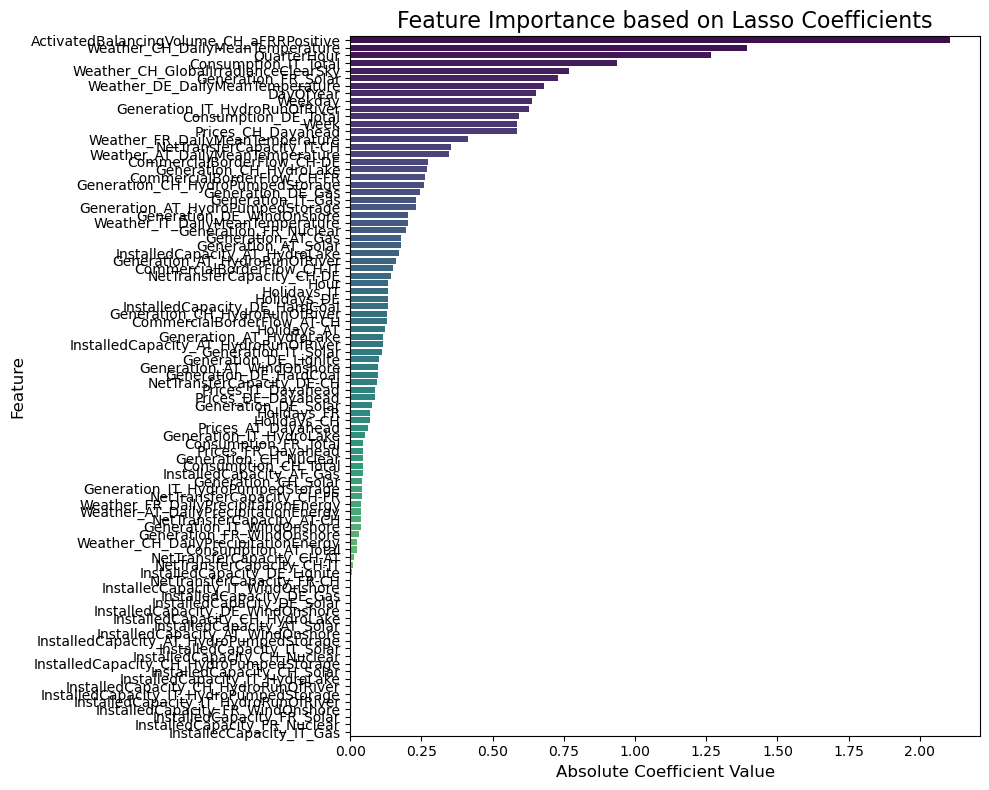

In [49]:
# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='AbsoluteCoefficient', y='Feature', data=coef_df, palette='viridis')

# Add labels and title
plt.title('Feature Importance based on Lasso Coefficients', fontsize=16)
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

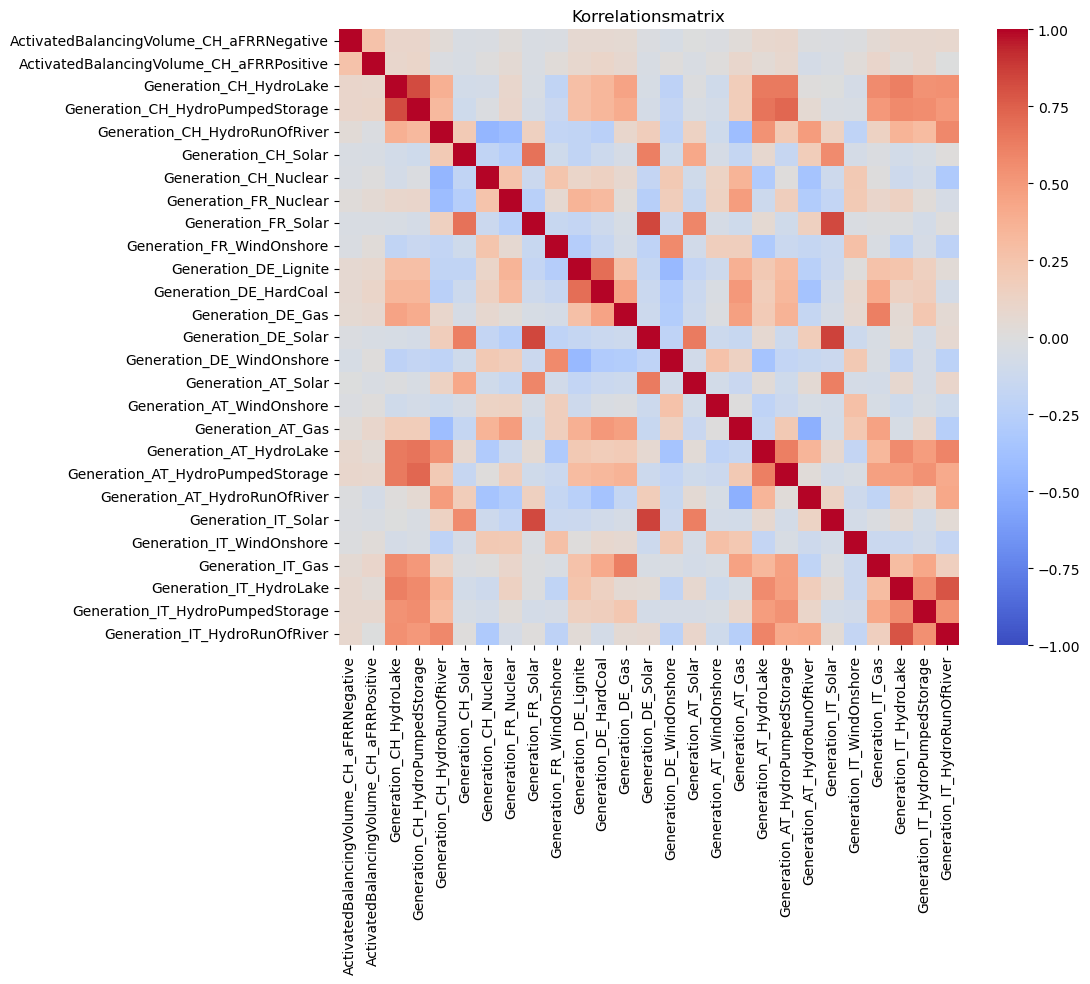

In [6]:
afrr_columns = ['ActivatedBalancingVolume_CH_aFRRNegative', 'ActivatedBalancingVolume_CH_aFRRPositive']
afrr_activation_selected = afrr_activation_df[afrr_columns]

# Füge die ausgewählten Spalten zu generation_df hinzu
df_gen_tot = pd.concat([afrr_activation_selected, generation_df], axis=1)

# Berechne die Korrelationsmatrix
correlation_matrix = df_gen_tot.corr()

# Erstelle eine Heatmap der Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Korrelationsmatrix')
plt.show()

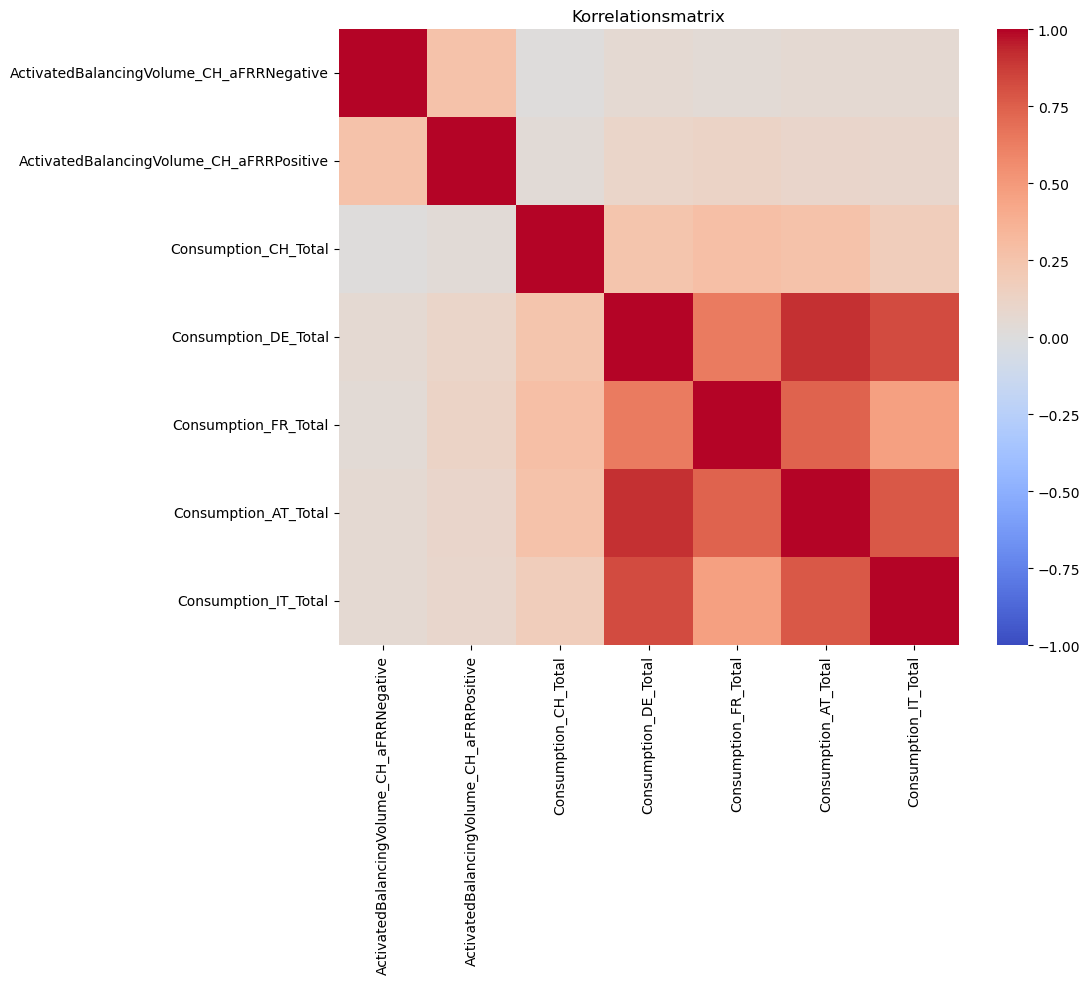

In [7]:
afrr_columns = ['ActivatedBalancingVolume_CH_aFRRNegative', 'ActivatedBalancingVolume_CH_aFRRPositive']
afrr_activation_selected = afrr_activation_df[afrr_columns]

# Füge die ausgewählten Spalten zu generation_df hinzu
df_con_tot = pd.concat([afrr_activation_selected, consumption_df], axis=1)

correlation_matrix = df_con_tot.corr()

# Erstelle eine Heatmap der Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Korrelationsmatrix')
plt.show()

In [ ]:
#Price vs. Net transfer capacity
#

In [10]:
input_features_df.columns

Index(['Unnamed: 0', 'Generation_CH_HydroLake',
       'Generation_CH_HydroPumpedStorage', 'Generation_CH_HydroRunOfRiver',
       'Generation_CH_Solar', 'Generation_CH_Nuclear',
       'InstalledCapacity_CH_HydroLake',
       'InstalledCapacity_CH_HydroPumpedStorage',
       'InstalledCapacity_CH_HydroRunOfRiver', 'InstalledCapacity_CH_Solar',
       'InstalledCapacity_CH_Nuclear', 'Generation_FR_Nuclear',
       'Generation_FR_Solar', 'Generation_FR_WindOnshore',
       'InstalledCapacity_FR_Nuclear', 'InstalledCapacity_FR_Solar',
       'InstalledCapacity_FR_WindOnshore', 'Generation_DE_Lignite',
       'Generation_DE_HardCoal', 'Generation_DE_Gas', 'Generation_DE_Solar',
       'Generation_DE_WindOnshore', 'InstalledCapacity_DE_Lignite',
       'InstalledCapacity_DE_HardCoal', 'InstalledCapacity_DE_Gas',
       'InstalledCapacity_DE_Solar', 'InstalledCapacity_DE_WindOnshore',
       'Generation_AT_Solar', 'Generation_AT_WindOnshore', 'Generation_AT_Gas',
       'Generation_AT_Hydro

In [27]:
# Filter für Generation- und Consumption-Spalten
df_flow_col = [col for col in all_columns if 'CommercialBorderFlow' in col]
df_ntc_col = [col for col in all_columns if 'NetTransferCapacity' in col]

# Erstelle DataFrames für die Generation- und Consumption-Spalten
df_flow = input_features_df[df_flow_col]
df_ntc = input_features_df[df_ntc_col]



In [18]:
df_flow

,CommercialBorderFlow_CH-DE,CommercialBorderFlow_CH-FR,CommercialBorderFlow_CH-IT,CommercialBorderFlow_AT-CH
0,-799.0,-2600.0,0.0,130.0
1,-799.0,-2600.0,0.0,130.0
2,-799.0,-2600.0,0.0,130.0
3,-799.0,-2600.0,0.0,130.0
4,-800.0,-2450.0,0.0,130.0
...,...,...,...,...
210307,-748.0,-2558.3,1134.0,379.0
210308,-748.0,-2286.0,1058.0,407.0
210309,-748.0,-2286.0,1058.0,407.0
210310,-748.0,-2286.0,1058.0,407.0


In [19]:
df_ntc

,NetTransferCapacity_CH-DE,NetTransferCapacity_DE-CH,NetTransferCapacity_CH-FR,NetTransferCapacity_FR-CH,NetTransferCapacity_CH-IT,NetTransferCapacity_IT-CH,NetTransferCapacity_AT-CH,NetTransferCapacity_CH-AT
0,4000.0,800.0,1200.0,3000.0,1778.0,1910.0,500.0,1200.0
1,4000.0,800.0,1200.0,3000.0,1778.0,1910.0,500.0,1200.0
2,4000.0,800.0,1200.0,3000.0,1778.0,1910.0,500.0,1200.0
3,4000.0,800.0,1200.0,3000.0,1778.0,1910.0,500.0,1200.0
4,4000.0,800.0,1200.0,3000.0,1778.0,1910.0,500.0,1200.0
...,...,...,...,...,...,...,...,...
210307,4000.0,800.0,1200.0,3200.0,1134.0,1910.0,900.0,1200.0
210308,4000.0,800.0,1200.0,3200.0,1058.0,1910.0,900.0,1200.0
210309,4000.0,800.0,1200.0,3200.0,1058.0,1910.0,900.0,1200.0
210310,4000.0,800.0,1200.0,3200.0,1058.0,1910.0,900.0,1200.0


In [35]:
import numpy as np 

# Calculate the ratio for CH-FR
df_flow['Flow_to_NTC_CH-FR'] = np.where(
    df_flow['CommercialBorderFlow_CH-FR'] > 0,
    df_flow['CommercialBorderFlow_CH-FR'] / df_ntc['NetTransferCapacity_CH-FR'],
    df_flow['CommercialBorderFlow_CH-FR'] / df_ntc['NetTransferCapacity_FR-CH']
)

# Calculate the ratio for CH-DE
df_flow['Flow_to_NTC_CH-DE'] = np.where(
    df_flow['CommercialBorderFlow_CH-DE'] > 0,
    df_flow['CommercialBorderFlow_CH-DE'] / df_ntc['NetTransferCapacity_CH-DE'],
    df_flow['CommercialBorderFlow_CH-DE'] / df_ntc['NetTransferCapacity_DE-CH']
)

# Calculate the ratio for CH-IT
df_flow['Flow_to_NTC_CH-IT'] = np.where(
    df_flow['CommercialBorderFlow_CH-IT'] > 0,
    df_flow['CommercialBorderFlow_CH-IT'] / df_ntc['NetTransferCapacity_CH-IT'],
    df_flow['CommercialBorderFlow_CH-IT'] / df_ntc['NetTransferCapacity_IT-CH']
)

# Calculate the ratio for AT-CH
df_flow['Flow_to_NTC_AT-CH'] = np.where(
    df_flow['CommercialBorderFlow_AT-CH'] > 0,
    df_flow['CommercialBorderFlow_AT-CH'] / df_ntc['NetTransferCapacity_AT-CH'],
    df_flow['CommercialBorderFlow_AT-CH'] / df_ntc['NetTransferCapacity_CH-AT']
)

df_flow

C:\Users\vogtr\AppData\Local\Temp\ipykernel_5124\1652735957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flow['Flow_to_NTC_CH-FR'] = np.where(
C:\Users\vogtr\AppData\Local\Temp\ipykernel_5124\1652735957.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flow['Flow_to_NTC_CH-DE'] = np.where(
C:\Users\vogtr\AppData\Local\Temp\ipykernel_5124\1652735957.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,CommercialBorderFlow_CH-DE,CommercialBorderFlow_CH-FR,CommercialBorderFlow_CH-IT,CommercialBorderFlow_AT-CH,Flow_to_NTC_CH-FR,Flow_to_NTC_CH-DE,Flow_to_NTC_CH-IT,Flow_to_NTC_AT-CH
0,-799.0,-2600.0,0.0,130.0,-0.866667,-0.99875,0.0,0.260000
1,-799.0,-2600.0,0.0,130.0,-0.866667,-0.99875,0.0,0.260000
2,-799.0,-2600.0,0.0,130.0,-0.866667,-0.99875,0.0,0.260000
3,-799.0,-2600.0,0.0,130.0,-0.866667,-0.99875,0.0,0.260000
4,-800.0,-2450.0,0.0,130.0,-0.816667,-1.00000,0.0,0.260000
...,...,...,...,...,...,...,...,...
210307,-748.0,-2558.3,1134.0,379.0,-0.799469,-0.93500,1.0,0.421111
210308,-748.0,-2286.0,1058.0,407.0,-0.714375,-0.93500,1.0,0.452222
210309,-748.0,-2286.0,1058.0,407.0,-0.714375,-0.93500,1.0,0.452222
210310,-748.0,-2286.0,1058.0,407.0,-0.714375,-0.93500,1.0,0.452222


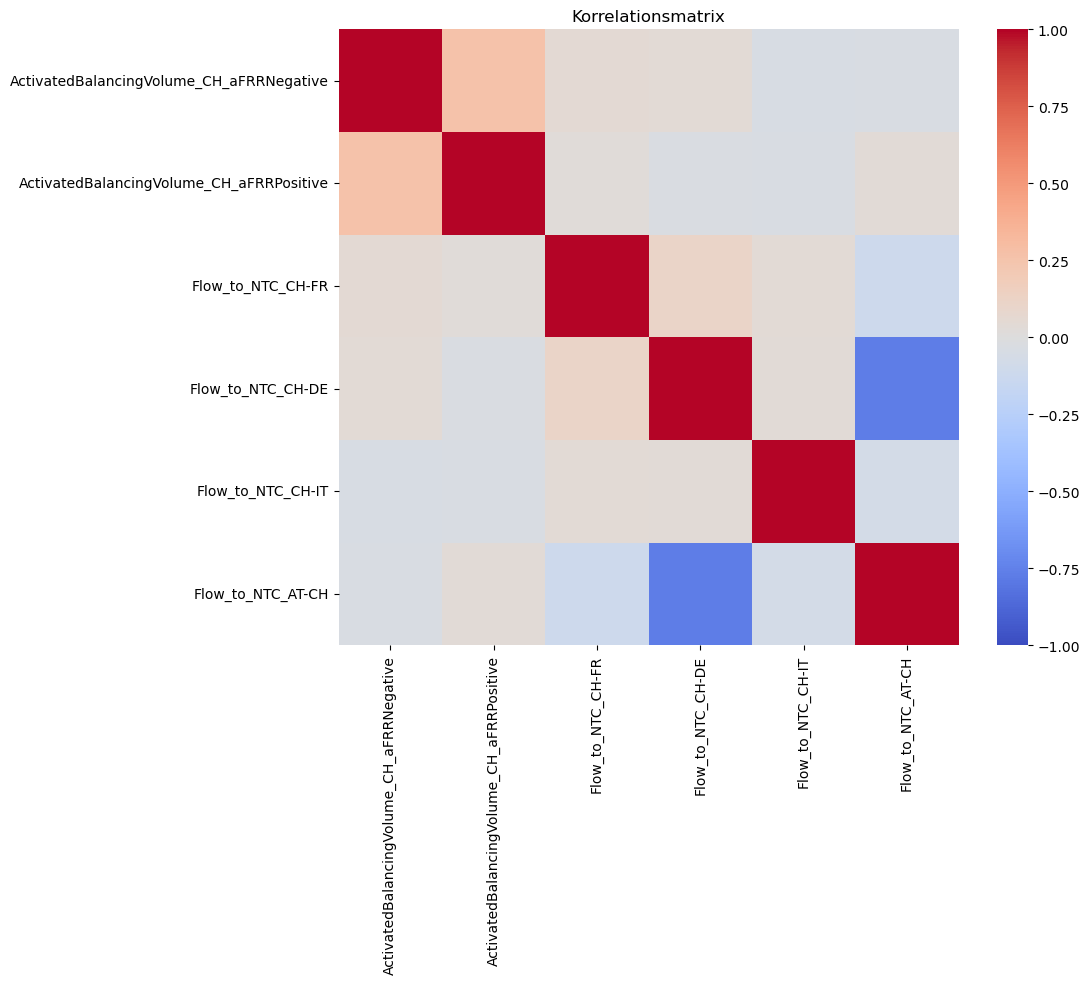

In [39]:
df_flow_rate = df_flow[['Flow_to_NTC_CH-FR','Flow_to_NTC_CH-DE','Flow_to_NTC_CH-IT','Flow_to_NTC_AT-CH']]
# Füge die ausgewählten Spalten zu generation_df hinzu
df_gen_tot = pd.concat([afrr_activation_selected, df_flow_rate], axis=1)

# Berechne die Korrelationsmatrix
correlation_matrix = df_gen_tot.corr()

# Erstelle eine Heatmap der Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Korrelationsmatrix')
plt.show()


In [37]:
df_flow['Flow_to_NTC_CH-FR']

0        -0.866667
1        -0.866667
2        -0.866667
3        -0.866667
4        -0.816667
            ...   
210307   -0.799469
210308   -0.714375
210309   -0.714375
210310   -0.714375
210311   -0.714375
Name: Flow_to_NTC_CH-FR, Length: 210312, dtype: float64

In [11]:
# Liste der CommercialBorderFlow- und NetTransferCapacity-Spalten
commercial_border_flow_columns = [col for col in input_features_df.columns if 'CommercialBorderFlow' in col]
net_transfer_capacity_columns = [col for col in input_features_df.columns if 'NetTransferCapacity' in col]

# Initialisiere ein leeres Dictionary für die Ergebnisse
results = {}

# Durchlaufe jede Kombination von CommercialBorderFlow- und NetTransferCapacity-Spalten
for cbf_col in commercial_border_flow_columns:
    for ntc_col in net_transfer_capacity_columns:
        if cbf_col.endswith(ntc_col.split('-')[1]):  # Match CommercialBorderFlow und NetTransferCapacity Spalten
            # Berechne das Verhältnis
            new_col_name = f'{cbf_col}_div_{ntc_col}'
            results[new_col_name] = input_features_df[cbf_col] / input_features_df[ntc_col]

# Erstelle ein DataFrame mit den Ergebnissen
df_results = pd.DataFrame(results)

# Ausgabe des resultierenden DataFrames
print("Results DataFrame:")
print(df_results.head())

Results DataFrame:
   CommercialBorderFlow_CH-DE_div_NetTransferCapacity_CH-DE  \
0                                           -0.19975          
1                                           -0.19975          
2                                           -0.19975          
3                                           -0.19975          
4                                           -0.20000          

   CommercialBorderFlow_CH-FR_div_NetTransferCapacity_CH-FR  \
0                                          -2.166667          
1                                          -2.166667          
2                                          -2.166667          
3                                          -2.166667          
4                                          -2.041667          

   CommercialBorderFlow_CH-IT_div_NetTransferCapacity_CH-IT  \
0                                                0.0          
1                                                0.0          
2                                 

In [12]:
df_results

,CommercialBorderFlow_CH-DE_div_NetTransferCapacity_CH-DE,CommercialBorderFlow_CH-FR_div_NetTransferCapacity_CH-FR,CommercialBorderFlow_CH-IT_div_NetTransferCapacity_CH-IT,CommercialBorderFlow_AT-CH_div_NetTransferCapacity_DE-CH,CommercialBorderFlow_AT-CH_div_NetTransferCapacity_FR-CH,CommercialBorderFlow_AT-CH_div_NetTransferCapacity_IT-CH,CommercialBorderFlow_AT-CH_div_NetTransferCapacity_AT-CH
0,-0.19975,-2.166667,0.0,0.16250,0.043333,0.068063,0.260000
1,-0.19975,-2.166667,0.0,0.16250,0.043333,0.068063,0.260000
2,-0.19975,-2.166667,0.0,0.16250,0.043333,0.068063,0.260000
3,-0.19975,-2.166667,0.0,0.16250,0.043333,0.068063,0.260000
4,-0.20000,-2.041667,0.0,0.16250,0.043333,0.068063,0.260000
...,...,...,...,...,...,...,...
210307,-0.18700,-2.131917,1.0,0.47375,0.118438,0.198429,0.421111
210308,-0.18700,-1.905000,1.0,0.50875,0.127188,0.213089,0.452222
210309,-0.18700,-1.905000,1.0,0.50875,0.127188,0.213089,0.452222
210310,-0.18700,-1.905000,1.0,0.50875,0.127188,0.213089,0.452222


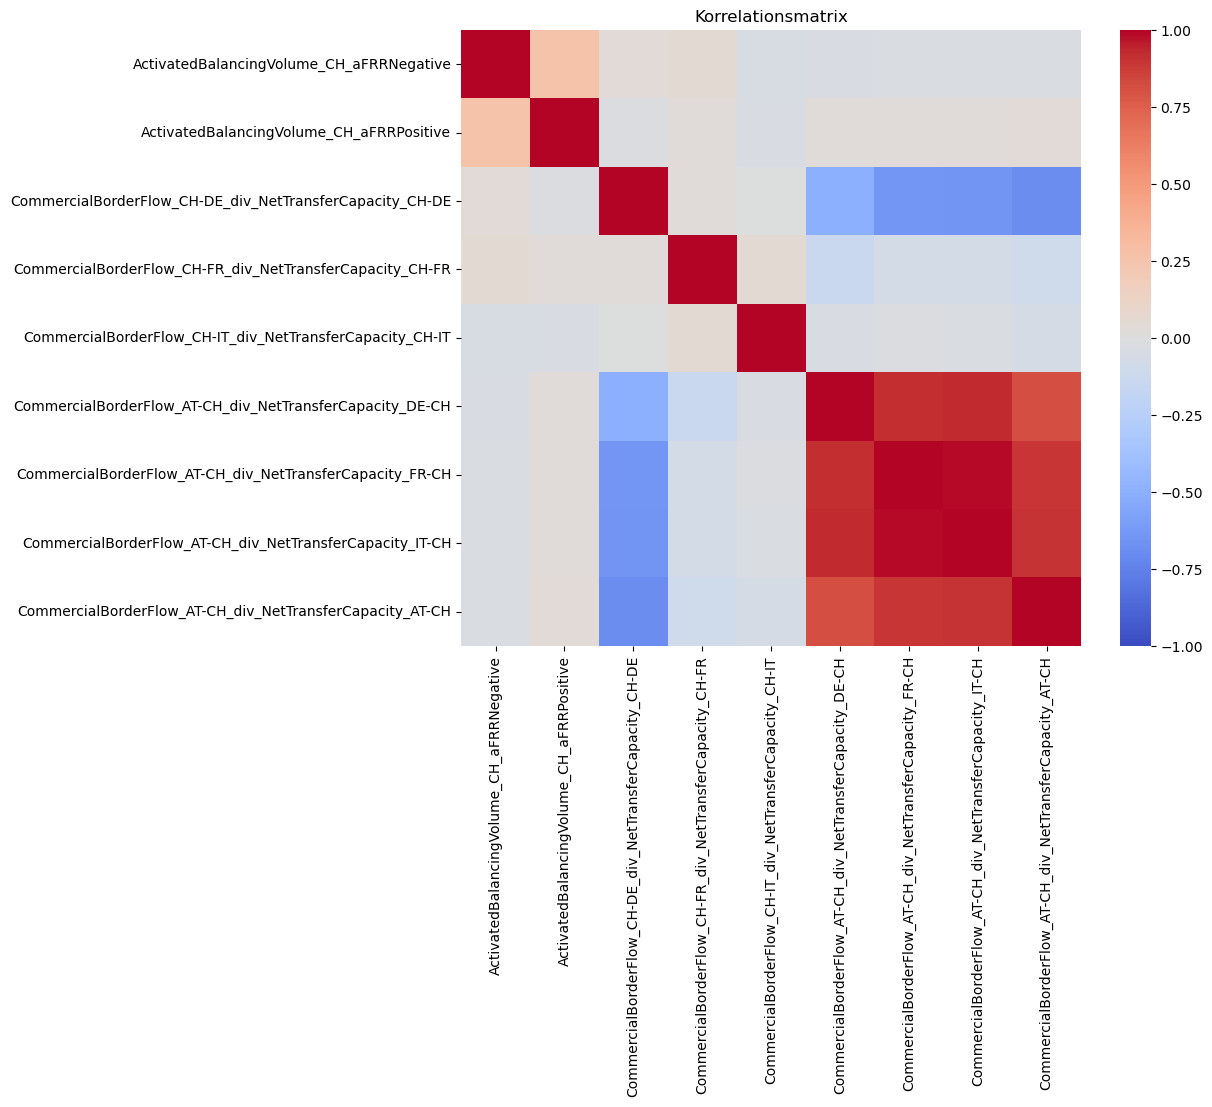

In [24]:

df_flow_div_ntc = pd.concat([afrr_activation_selected, df_results], axis=1)

correlation_matrix = df_flow_div_ntc.corr()

# Erstelle eine Heatmap der Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Korrelationsmatrix')
plt.show()

In [25]:
afrr_activation_selected

,ActivatedBalancingVolume_CH_aFRRNegative,ActivatedBalancingVolume_CH_aFRRPositive
0,-1.800,0.000
1,-0.100,0.000
2,0.000,4.600
3,0.000,1.200
4,0.000,20.100
...,...,...
210331,-0.406,0.177
210332,-0.229,2.558
210333,-1.200,0.174
210334,-3.154,0.019
